<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/processed/kk_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-02-13
Version: 1.0

Description:
    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data
    to understand its characteristics (e.g., text length, word frequency)
    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.

===================================================
"""

'\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-02-13\nVersion: 1.0\n\nDescription:\n    This notebook conducts descriptive analysis on the preprocessed earnings calls transcript data\n    to understand its characteristics (e.g., text length, word frequency)\n    and generate visualisations (word clouds, histograms) to highlight trends or anomalies.\n\n===================================================\n'

# 1. Import libraries and files

In [8]:
import os
import sys
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import islice
from nltk.util import ngrams
from wordcloud import WordCloud

In [3]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
print(os.listdir(BOE_path))

Mounted at /content/drive
['ubs_management_discussion_preprocessed.csv', 'ubs_qna_df_preprocessed.csv', 'Archived', 'JP Mogran processed thru OpenAI', 'jpmorgan_qna_df_preprocessed_final.csv', 'jpmorgan_management_df_preprocessed_final.csv']


Note: I will start with JPM data for each quarter between 2023-2024.

I have listened to the Q42024 call. My impressions from the call (I do not have investment finance experience)
* Overall positive sentiment.
* 'We remain optimistic' theme across the call.
* Good investments have returned good returns overall.
* CEO leaves in 5 years (mentioned health problems).
* JPM is driving efficiencies in developer departments as part of long term, holistic practice.
* Key vulnerability same as for eveyrone else: unemployment rates that drive credit.

In [4]:
# Load JPM preprocessed transcripts

files = os.listdir(BOE_path)

jp_morgan_files = [
    'jpmorgan_qna_df_preprocessed_final.csv',
    'jpmorgan_management_df_preprocessed_final.csv',
]

for file in jp_morgan_files:
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        print(f"\n📌 **File: {file}**")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")


📌 **File: jpmorgan_qna_df_preprocessed_final.csv**
['Index', 'Quarter-Year', 'Question', 'Question_cleaned', 'Asked By', 'Role of the person asked the question', 'Answer', 'Answer_cleaned', 'Answered By', 'Role of the person answered the question']

📌 **File: jpmorgan_management_df_preprocessed_final.csv**
['Index', 'Quarter-Year', 'Text', 'Text_cleaned']


Steps below are to help us
- **assess data quality**
- **understand text characteristics**
- **identify anomalies before further analysis**

# 2. Analyse data structure & text length

🔎 Missing Values in Q&A Data:
 Index                                       0
Quarter-Year                                0
Question                                    1
Question_cleaned                            0
Asked By                                    1
Role of the person asked the question       1
Answer                                      2
Answer_cleaned                              0
Answered By                                 2
Role of the person answered the question    2
dtype: int64

🔎 Missing Values in Management Discussion Data:
 Index           8
Quarter-Year    0
Text            0
Text_cleaned    0
dtype: int64


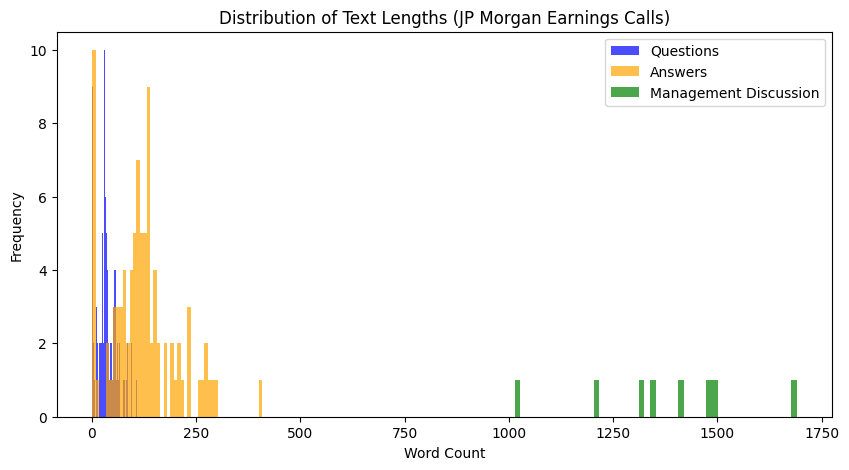


📌 Summary Statistics:
Q&A Questions: count     91.000000
mean      38.252747
std       25.052209
min        1.000000
25%       24.500000
50%       34.000000
75%       54.000000
max      112.000000
Name: question_word_count, dtype: float64
Q&A Answers: count     91.000000
mean     123.131868
std       79.252930
min        1.000000
25%       75.000000
50%      116.000000
75%      152.500000
max      409.000000
Name: answer_word_count, dtype: float64
Management Discussion: count       8.000000
mean     1371.625000
std       203.431236
min      1014.000000
25%      1287.000000
50%      1383.500000
75%      1486.000000
max      1690.000000
Name: text_word_count, dtype: float64


In [5]:
# Check missing values, text length distribution, and compare response length trends

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

# Check for missing values
print("🔎 Missing Values in Q&A Data:\n", qna_df.isnull().sum())
print("\n🔎 Missing Values in Management Discussion Data:\n", management_df.isnull().sum())

# Compute word counts
qna_df["question_word_count"] = qna_df["Question_cleaned"].astype(str).apply(lambda x: len(x.split()))
qna_df["answer_word_count"] = qna_df["Answer_cleaned"].astype(str).apply(lambda x: len(x.split()))
management_df["text_word_count"] = management_df["Text_cleaned"].astype(str).apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(10, 5))
plt.hist(qna_df["question_word_count"], bins=50, alpha=0.7, label="Questions", color='blue')
plt.hist(qna_df["answer_word_count"], bins=50, alpha=0.7, label="Answers", color='orange')
plt.hist(management_df["text_word_count"], bins=50, alpha=0.7, label="Management Discussion", color='green')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths (JP Morgan Earnings Calls)")
plt.legend()
plt.show()

# Summary statistics
print("\n📌 Summary Statistics:")
print("Q&A Questions:", qna_df["question_word_count"].describe())
print("Q&A Answers:", qna_df["answer_word_count"].describe())
print("Management Discussion:", management_df["text_word_count"].describe())

- ❗**Missing values** - minor missing values (manual check revealed there is one row of data that separates 2023-2024 but is otherwise empty, also one question "Are you there?" with no answer - these are most likely the culprits, and it should be fine to remove them)
- ❗**Text length distribution** - some answers are very short and more data cleaning could be done here (examples printed below)
- 💡**Summary statistics** - The average question length is ~38 words, while the average answer is ~123 words, confirming that executives provide detailed responses to analyst questions. Q&A responses show high variability (std = 79 words), meaning some answers are much longer than others.

In [7]:
# Print examples of short answers (fewer than 5 words)

short_answers = qna_df[qna_df["answer_word_count"] < 5][["Answer_cleaned", "Answered By", "Quarter-Year"]]

print(" Examples of Very Short Answers:\n")
print(short_answers.head(10))

 Examples of Very Short Answers:

                    Answer_cleaned    Answered By Quarter-Year
11  ['excellent folks thank much']    Jamie Dimon         1Q23
17                         ['nan']            NaN         2Q23
25              ['thank you guys']    Jamie Dimon         2Q23
37                  ['thank much']    Jamie Dimon         3Q23
48   ['okay thanks much everyone']  Jeremy Barnum         4Q23
54                         ['nan']            NaN         1Q24


❗Most short answers are polite phrases (e.g., "thank you guys", "okay thanks much everyone"), which are not substantive responses. These may be excluded from topic modeling & sentiment analysis to avoid skewed results.

# 3. Get word frequency & key themes

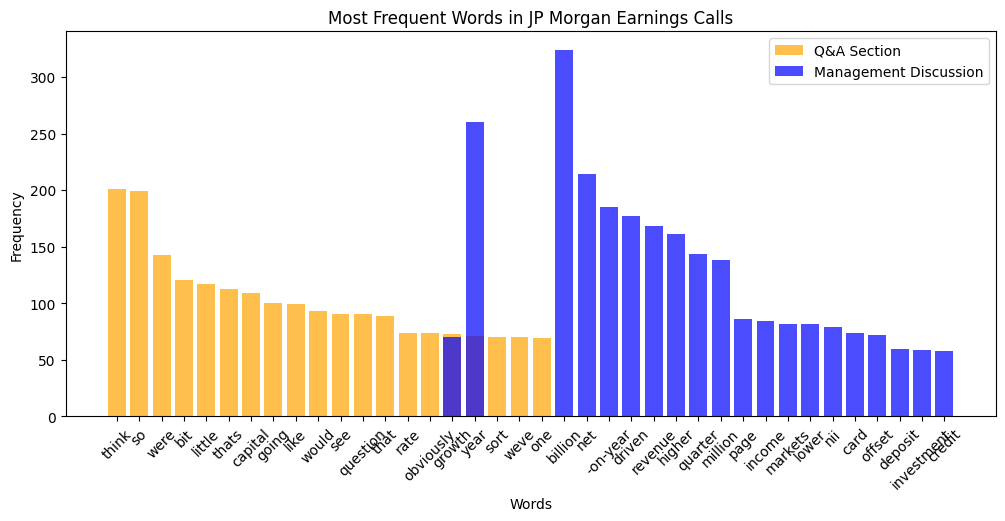

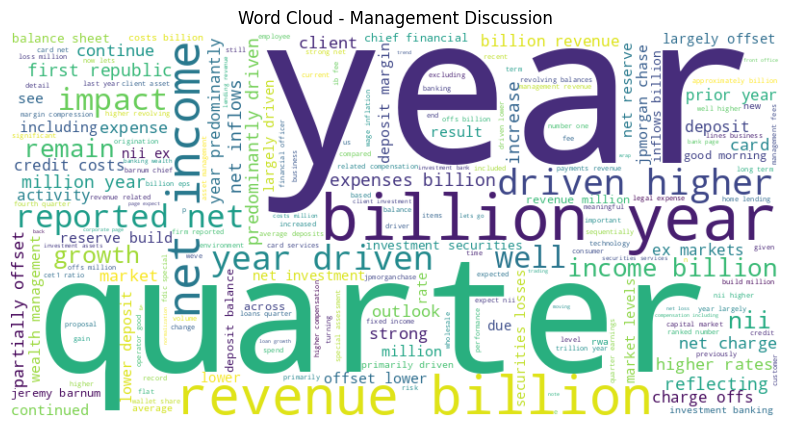

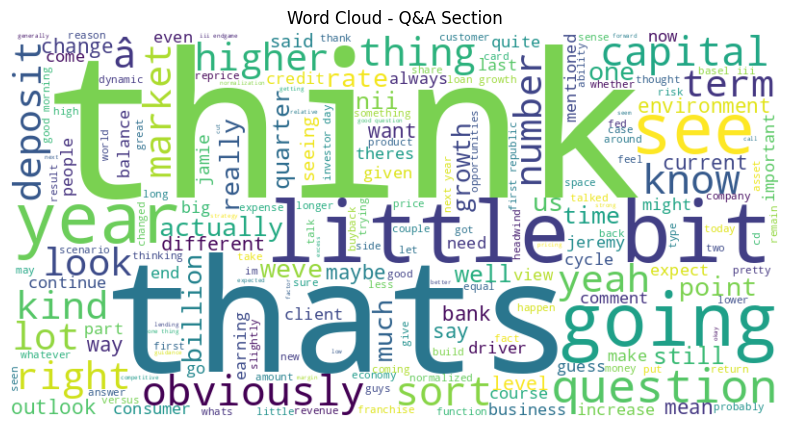


🔎 Top Bigrams in Q&A:
 [(('little', 'bit'), 95), (('loan', 'growth'), 23), (('were', 'going'), 20), (('basel', 'iii'), 19), (('first', 'republic'), 18), (('investor', 'day'), 17), (('so', 'think'), 17), (('good', 'morning'), 15), (('next', 'year'), 15), (('iii', 'endgame'), 15), (('else', 'equal'), 15), (('so', 'thats'), 12), (('rate', 'paid'), 12), (('good', 'question'), 12), (('yield', 'curve'), 12)]

🔎 Top Bigrams in Management Discussion:
 [(('year', '-on-year'), 185), (('net', 'income'), 61), (('driven', 'higher'), 60), (('reported', 'net'), 46), (('-on-year', 'driven'), 42), (('predominantly', 'driven'), 37), (('net', 'inflows'), 37), (('first', 'republic'), 37), (('partially', 'offset'), 32), (('higher', 'rates'), 31), (('net', 'charge'), 30), (('billion', 'revenue'), 28), (('credit', 'costs'), 27), (('ex', 'markets'), 26), (('quarter', '-on-quarter'), 25)]

🔎 Top Trigrams in Q&A:
 [(('basel', 'iii', 'endgame'), 15), (("['hey", 'good', 'morning'), 9), (('net', 'interest', 'inco

In [9]:
# Extract most common words, frequent financial phrases, compare Q&A and management topics

qna_df = pd.read_csv(f"{BOE_path}/jpmorgan_qna_df_preprocessed_final.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_df_preprocessed_final.csv")

# concatenate text for analysis
qna_text = ' '.join(qna_df["Question_cleaned"].dropna()) + ' ' + ' '.join(qna_df["Answer_cleaned"].dropna())
management_text = ' '.join(management_df["Text_cleaned"].dropna())

# function to get most common words
def get_most_common_words(text, top_n=20):
    words = text.split()
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

# function to generate and count n-grams
def get_most_common_ngrams(text, n=2, top_n=15):
    words = text.split()
    ngram_list = list(ngrams(words, n))
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_n)

# get word frequencies
top_words_qna = get_most_common_words(qna_text)
top_words_mgmt = get_most_common_words(management_text)

# get bigrams & trigrams
top_bigrams_qna = get_most_common_ngrams(qna_text, n=2)
top_bigrams_mgmt = get_most_common_ngrams(management_text, n=2)
top_trigrams_qna = get_most_common_ngrams(qna_text, n=3)
top_trigrams_mgmt = get_most_common_ngrams(management_text, n=3)

# convert to df for visualization
df_qna_words = pd.DataFrame(top_words_qna, columns=['Word', 'Frequency'])
df_mgmt_words = pd.DataFrame(top_words_mgmt, columns=['Word', 'Frequency'])

# plot most common words
plt.figure(figsize=(12, 5))
plt.bar(df_qna_words['Word'], df_qna_words['Frequency'], alpha=0.7, label='Q&A Section', color='orange')
plt.bar(df_mgmt_words['Word'], df_mgmt_words['Frequency'], alpha=0.7, label='Management Discussion', color='blue')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# word cloud for management discussion
wordcloud_mgmt = WordCloud(width=800, height=400, background_color='white').generate(management_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Management Discussion")
plt.show()

# word cloud for q&A section
wordcloud_qa = WordCloud(width=800, height=400, background_color='white').generate(qna_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Q&A Section")
plt.show()

# print top bigrams & trigrams
print("\n🔎 Top Bigrams in Q&A:\n", top_bigrams_qna)
print("\n🔎 Top Bigrams in Management Discussion:\n", top_bigrams_mgmt)
print("\n🔎 Top Trigrams in Q&A:\n", top_trigrams_qna)
print("\n🔎 Top Trigrams in Management Discussion:\n", top_trigrams_mgmt)

**Word Frequency (Bar Chart & Word Clouds)**

- Management Discussion is dominated by terms like "billion," "revenue," "net income," and "quarter", reflecting structured reporting of financial results.
- Q&A Section contains conversational fillers like "think," "sort of," "little bit," alongside financial terms ("capital," "market," "growth"), suggesting a mix of informal discussion and analysis-driven questioning.

❗Consider removing non-informative filler words (e.g., "think," "little bit," "obviously") from Q&A in future preprocessing.



# 4. Sentiment readiness check

Check for positive/negative words present, any potential biases in wording, check for any sentiment anomalies

# 5. Speaker & Role-Based Analysis (Q&A only)




Who drives discussions, how does engagement vary per role, trends over time

# Archive - EDA run on initial preprocessed data by Chiaki (13/02)

In [ ]:
# Load JPM preprocessed transcripts

files = os.listdir(BOE_path)

jp_morgan_files = [
    'jpmorgan_preprocessed_transcript.csv',
    'jpmorgan_management_discussion_preprocessed .csv',
    'jpmorgan_qa_section_preprocessed.csv',
    'unfiltered_preprocessed_JP_qa_sec.csv'
]

for file in jp_morgan_files:
    file_path = os.path.join(BOE_path, file)

    try:
        df = pd.read_csv(file_path, nrows=5)
        print(f"\n📌 **File: {file}**")
        print(df.columns.tolist())
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")


📌 **File: jpmorgan_preprocessed_transcript.csv**
['filename', 'chunks', 'quarter', 'call_date']

📌 **File: jpmorgan_management_discussion_preprocessed .csv**
['filename', 'chunk_index', 'chunk_text', 'financial_quarter', 'call_date', 'tokenized_data', 'cleaned_data']

📌 **File: jpmorgan_qa_section_preprocessed.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date', 'tokenised_data', 'cleaned_data']

📌 **File: unfiltered_preprocessed_JP_qa_sec.csv**
['speaker', 'marker', 'job_title', 'utterance', 'filename', 'financial_quarter', 'call_date']


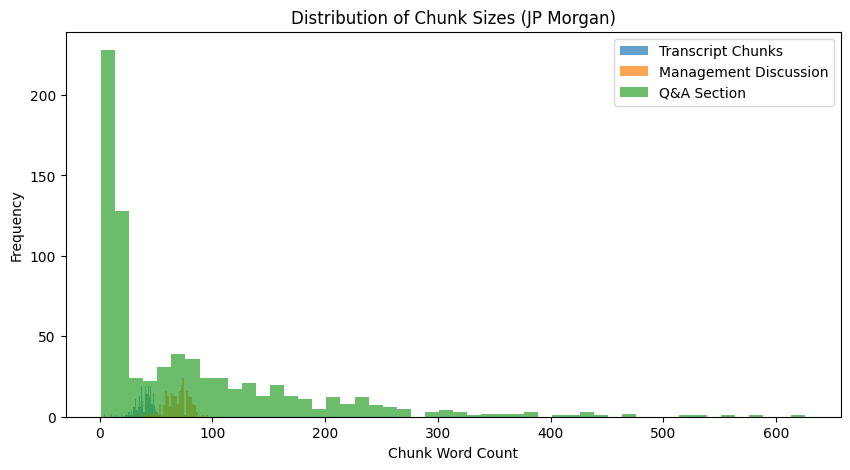

In [ ]:
# Calculate word count per chunk in each dataset

BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'
transcript_df = pd.read_csv(f"{BOE_path}/jpmorgan_preprocessed_transcript.csv")
management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv") # loading file with space between final period
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def calculate_word_counts(df, text_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df

transcript_df = calculate_word_counts(transcript_df, 'chunks')
management_df = calculate_word_counts(management_df, 'chunk_text')
qa_df = calculate_word_counts(qa_df, 'utterance')

# Chunk Size Distribution (All Text)
plt.figure(figsize=(10,5))
plt.hist(transcript_df['word_count'], bins=50, alpha=0.7, label='Transcript Chunks')
plt.hist(management_df['word_count'], bins=50, alpha=0.7, label='Management Discussion')
plt.hist(qa_df['word_count'], bins=50, alpha=0.7, label='Q&A Section')
plt.xlabel("Chunk Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Chunk Sizes (JP Morgan)")
plt.legend()
plt.show()

Observation: **Inconsistent chunking** in Q&A with many short chunks (<50 words) suggesting fragmented responses, while longer chunks (up to 600+ words) are rare.


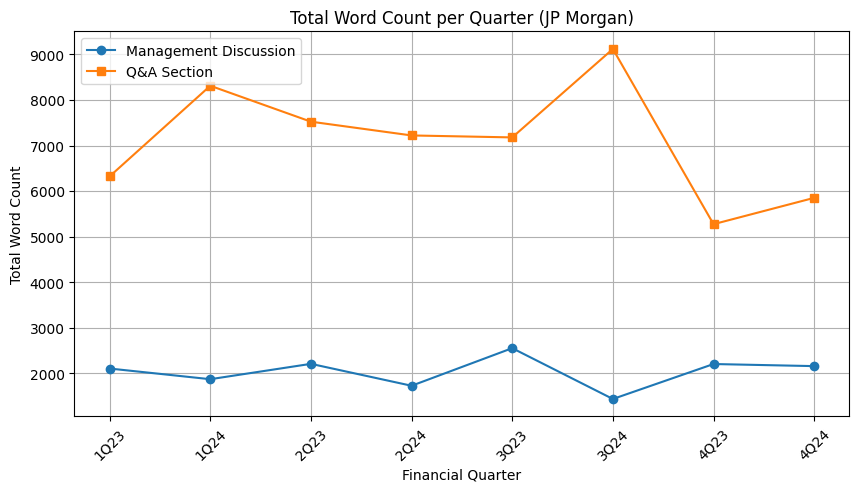

In [ ]:
# Get word count per quarter

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

def compute_word_count(df, text_column, date_column):
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    return df.groupby(date_column)['word_count'].sum().reset_index()

management_word_count = compute_word_count(management_df, 'chunk_text', 'financial_quarter')
qa_word_count = compute_word_count(qa_df, 'utterance', 'financial_quarter')

plt.figure(figsize=(10, 5))
plt.plot(management_word_count['financial_quarter'], management_word_count['word_count'], marker='o', label='Management Discussion')
plt.plot(qa_word_count['financial_quarter'], qa_word_count['word_count'], marker='s', label='Q&A Section')

plt.xlabel("Financial Quarter")
plt.ylabel("Total Word Count")
plt.title("Total Word Count per Quarter (JP Morgan)")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()


Observation
- **Q&A Sections Are Significantly Longer** - Q&A word count consistently exceeds 6,000-9,000 words per quarter, while Management Discussion remains relatively stable (~1,500-3,000 words)
- **Q&A Section Shows More Volatility** - Noticeable Q&A peaks in 1Q24 and 3Q24 (8,000-9,000 words) followed by a sharp drop in 4Q23 (5,000 words)
- The small Management dip in 3Q24 followed by a slight rebound suggests a possible seasonal effect or reporting structure shift.

Action: Could consider separating trends by speaker roles in Q&A to understand if certain executives driving longer discussions, or if analysts are becoming more vocal. Could also compare with external events to see if the earnings were surprises or if there were market movements that cause longer Q&As.

**(I checked for macroeconomic events around the 3Q23 dip and there was economic stagnation in the UK (zero growth)  with elevated corporate borrowing rates, this could have driven shorter discussions due to limited new developments, and focus on cost management and cautious outlooks. Conversely, around the 3Q24 spike, there was global economic growth (2.52% growth) and monetary policy adjustments (reducing rates) which may have led to longer discussions)**

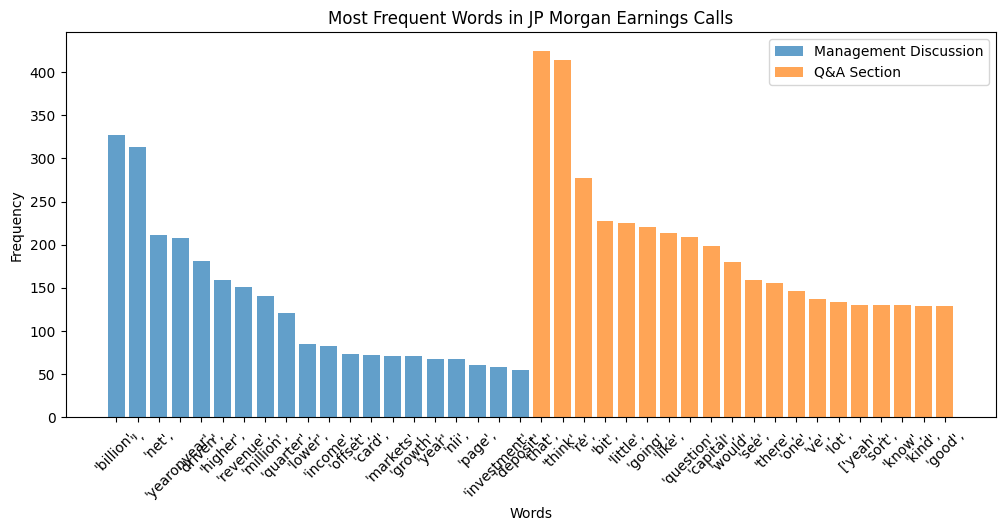

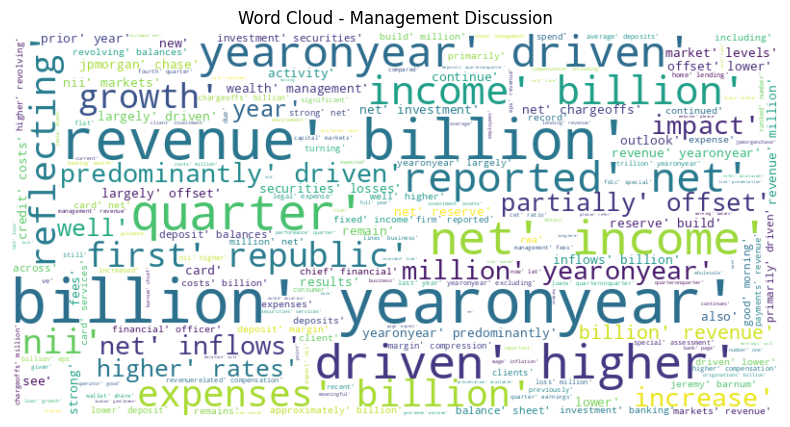

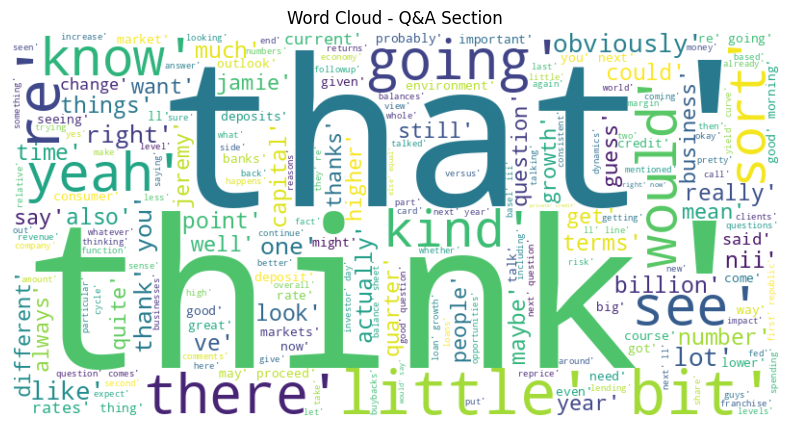

In [ ]:
# Word frequency with word cloud

management_df = pd.read_csv(f"{BOE_path}/jpmorgan_management_discussion_preprocessed .csv")
qa_df = pd.read_csv(f"{BOE_path}/jpmorgan_qa_section_preprocessed.csv")

# had to add this as the columns are named slightly differently
text_column_mgmt = 'tokenized_data'
text_column_qa = 'tokenised_data'

def get_most_common_words(df, text_column, top_n=20):
    all_words = ' '.join(df[text_column].dropna()).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

top_words_management = get_most_common_words(management_df, text_column_mgmt)
top_words_qa = get_most_common_words(qa_df, text_column_qa)

df_management_words = pd.DataFrame(top_words_management, columns=['Word', 'Frequency'])
df_qa_words = pd.DataFrame(top_words_qa, columns=['Word', 'Frequency'])

# plot most common words
plt.figure(figsize=(12, 5))
plt.bar(df_management_words['Word'], df_management_words['Frequency'], alpha=0.7, label='Management Discussion')
plt.bar(df_qa_words['Word'], df_qa_words['Frequency'], alpha=0.7, label='Q&A Section')
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Frequent Words in JP Morgan Earnings Calls")
plt.legend()
plt.show()

# plot word cloud for management discussion
wordcloud_mgmt = WordCloud(width=800, height=400, background_color='white').generate(' '.join(management_df[text_column_mgmt].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_mgmt, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Management Discussion")
plt.show()

# plot word cloud for Q&A section
wordcloud_qa = WordCloud(width=800, height=400, background_color='white').generate(' '.join(qa_df[text_column_qa].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_qa, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Q&A Section")
plt.show()

- Management Discussion is dominated by financial terms (e.g., billion, revenue, income, year-on-year)
- Q&A, due to a more conversational style, contains excessive filler words ("kind of", "little bit", "sort of"), indicating a need for improved stopword filtering to refine key insights.

**Action: Enhance stopword removal in Q&A to eliminate conversational clutter.**

Chunk Size Distribution – How long are the chunks? Are they too short or too long?

Word Count per Quarter – Does discussion length vary across quarters?

Comparison: Management Discussion vs Q&A – Are Q&A sections shorter or longer than management discussions?